# PREPARAZIONE

In [1]:
# Importazione delle librerie necessarie

import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import scipy.stats as stats
import pandas as pd
import seaborn as sns
from sklearn.utils import shuffle
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Montaggio di Google Drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Funzione per visualizzare le waveforms

def waveplot(ax, data, sr, emotion):
    ax.set_title(f'Emozione: {emotion}', size=14)
    librosa.display.waveshow(data, sr=sr, alpha=0.5, color='green', ax=ax)
    ax.set_xlabel('Tempo (s)')
    ax.set_ylabel('Ampiezza')
    ax.grid()

In [4]:
# Funzione per visualizzare gli spettrogrammi

def spectogram(ax, data, sr, emotion):
  x = librosa.stft(data)
  xdb = librosa.amplitude_to_db(abs(x))
  librosa.display.specshow(xdb, sr=sr, x_axis='time', y_axis='hz', ax=ax)
  ax.set_title(f'Emozione: {emotion}', size=14)
  ax.set_xlabel('Tempo (s)')
  ax.set_ylabel('Frequenza (Hz)')

In [5]:
# Funzione generale per la visualizzazione di waveforms e spettrogrammi

def plot_grid_3x2(df, plot_func, title):
    emozioni = df['label'].unique()
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))
    fig.suptitle(title, size=16)
    for i, emotion in enumerate(emozioni):
        example = df[df['label'] == emotion].iloc[0]
        audio_path = example['path']
        data, sr = librosa.load(audio_path, sr=None)
        plot_func(axes[i // 2, i % 2], data, sr, emotion)
    for j in range(len(emozioni), 6):
        fig.delaxes(axes[j // 2, j % 2])
    plt.tight_layout()
    plt.show()

In [6]:
# Funzione per creare e visualizzare i grafici a barre per le distribuzioni delle emozioni in X-train, X_test e X_val

def plot_emotion_distributions(train_counts, val_counts, test_counts, title="Distribuzione delle Emozioni"):
    emozioni = sorted(list(set(train_counts.keys()).union(set(val_counts.keys()), set(test_counts.keys()))))
    fig, axes = plt.subplots(3, 2, figsize=(15, 10))
    fig.suptitle(title, size=16)
    def plot_bar(ax, counts, title):
        ax.bar(counts.keys(), counts.values(), color='green')
        ax.set_title(title)
        ax.set_xlabel('Emozione')
        ax.set_ylabel('Numero di File')
        ax.set_xticklabels(counts.keys(), rotation=45, ha='right')
    plot_bar(axes[0, 0], train_counts, 'X_train - Distribuzione delle Emozioni')
    plot_bar(axes[0, 1], val_counts, 'X_val - Distribuzione delle Emozioni')
    plot_bar(axes[1, 0], test_counts, 'X_test - Distribuzione delle Emozioni')
    fig.delaxes(axes[1, 1])
    fig.delaxes(axes[2, 0])
    fig.delaxes(axes[2, 1])
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()

In [7]:
# Funzione per concatenare le features

def safe_concatenate(row):
    arrays = [val if isinstance(val, np.ndarray) and val.size > 0 else np.array([val]) if val is not None else np.array([])
              for val in row.values]
    arrays = [arr[None] if arr.ndim == 0 and arr.size > 0 else arr for arr in arrays]
    if len(set(arr.ndim for arr in arrays if arr.size > 0)) > 1:
        dims = [arr.ndim for arr in arrays]
        raise ValueError(f"Arrays have inconsistent dimensions: {dims}")

    return np.concatenate(arrays)

In [8]:
# Lettura del dataset generale

df = pd.read_pickle('/content/drive/MyDrive/ABEC/Base.pkl')

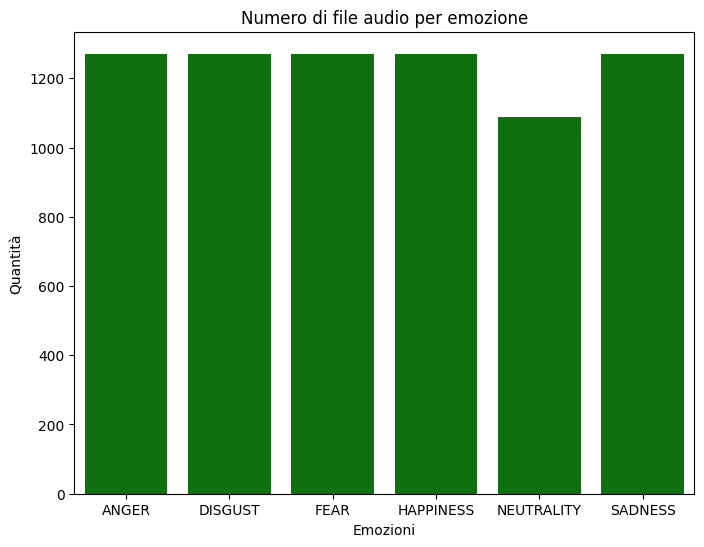

In [9]:
# Visualizzazione del numero di file audio per emozione

df['label'].value_counts()
plt.figure(figsize=(8, 6))
sns.countplot(x=df['label'], data=df, color='green')
plt.ylabel('Quantità')
plt.xlabel('Emozioni')
plt.title('Numero di file audio per emozione')
plt.show()

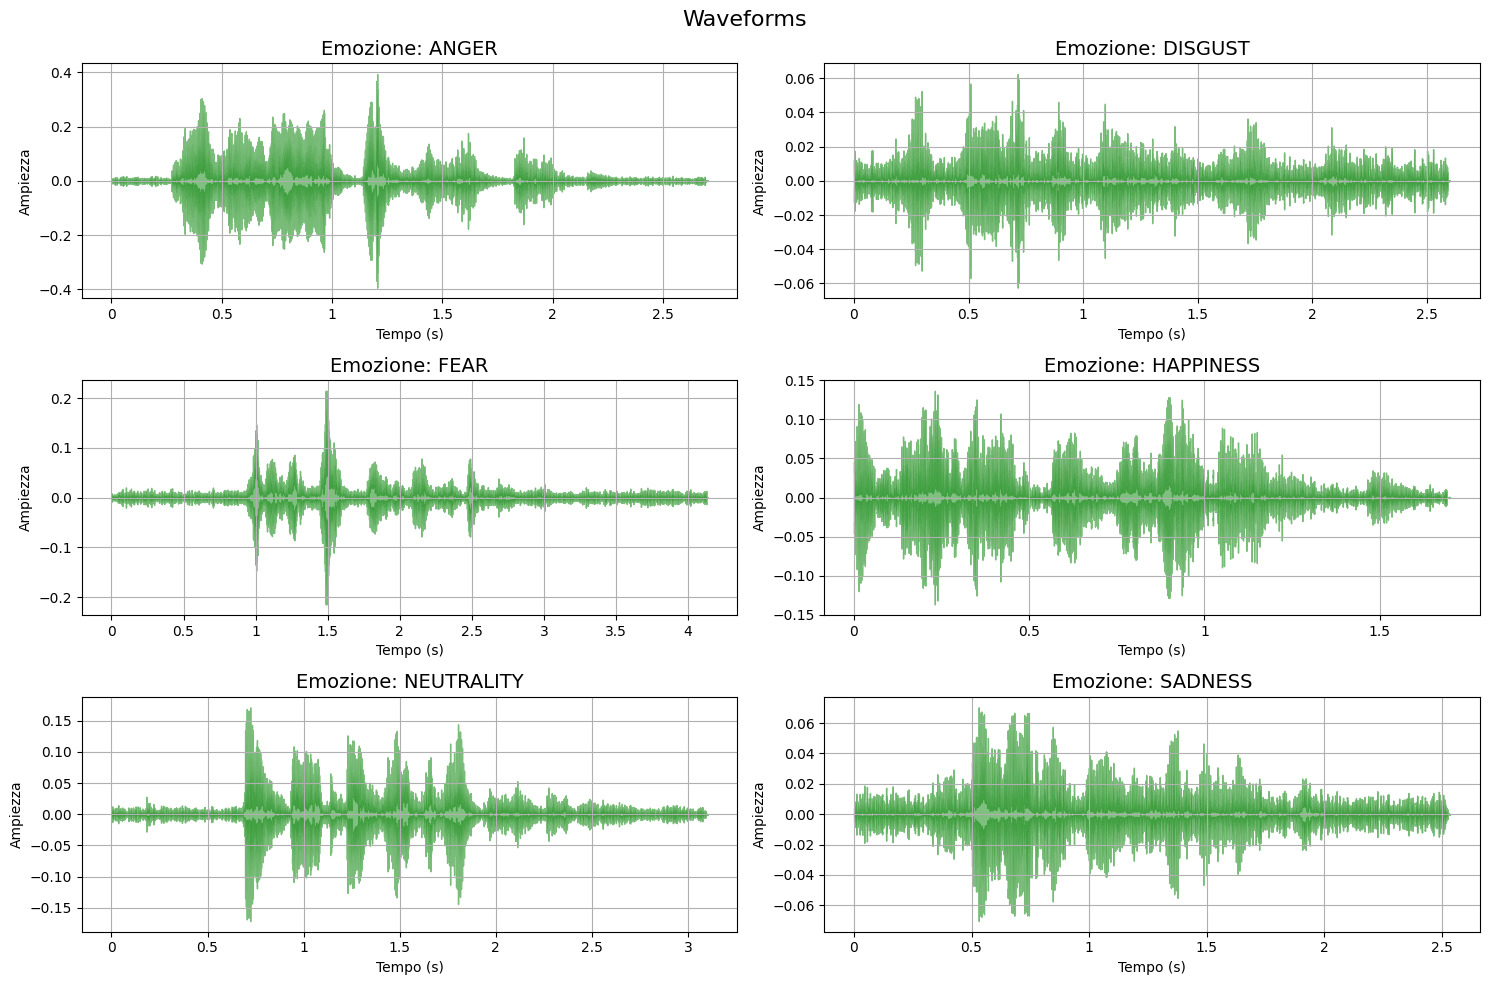

In [10]:
# Visualizzazione delle waveforms

plot_grid_3x2(df, waveplot, 'Waveforms')

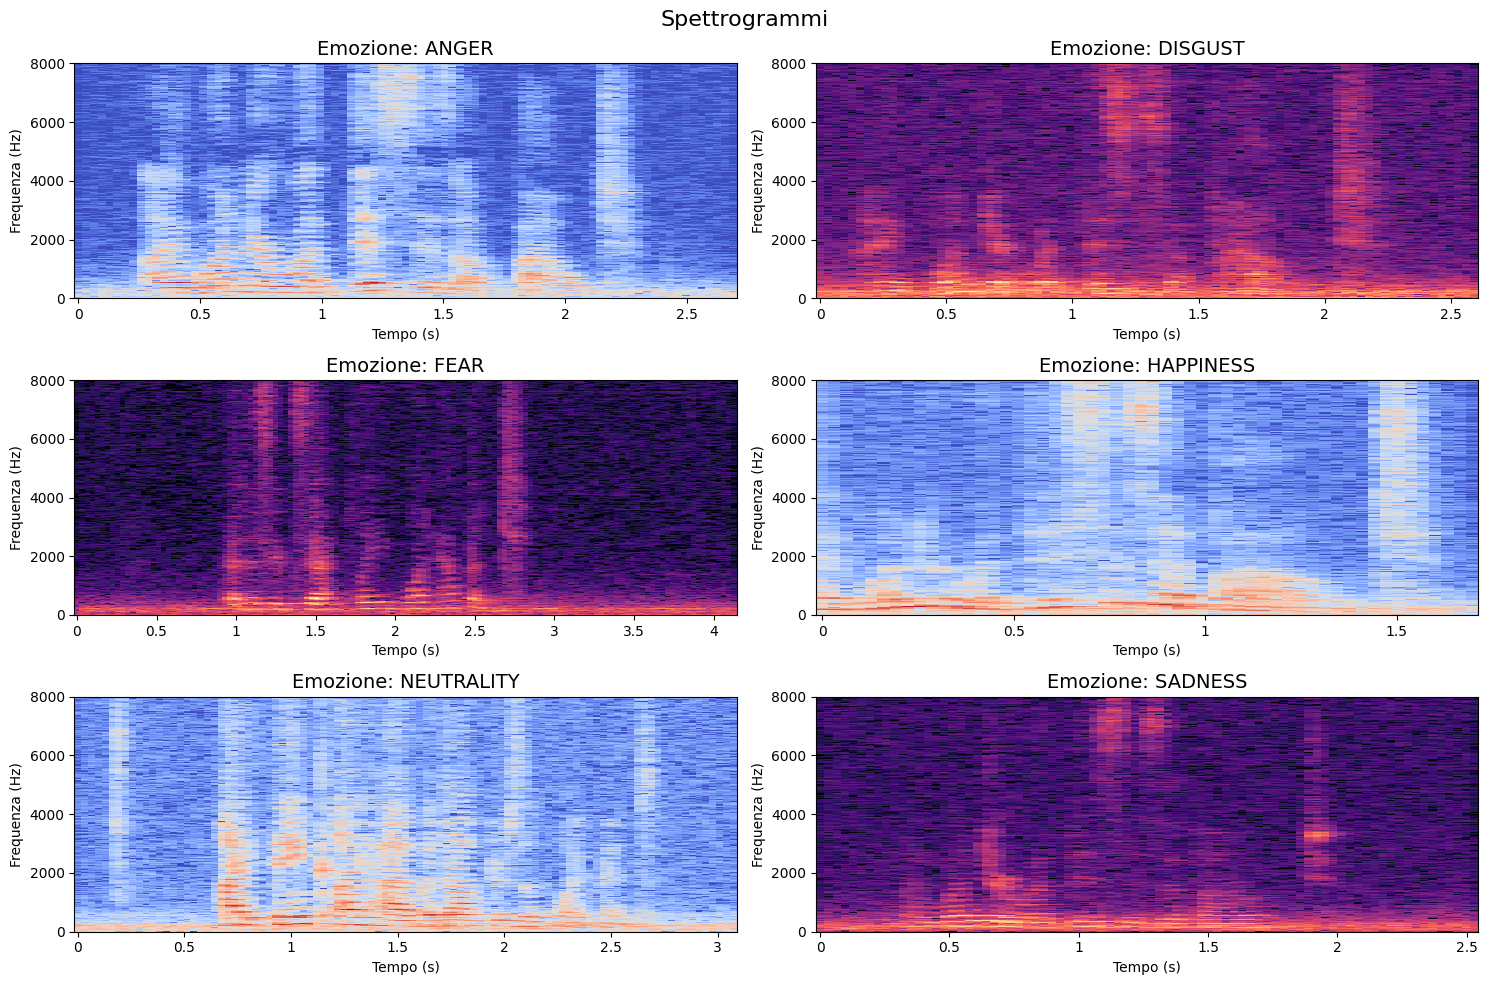

In [11]:
# Visualizzazione degli spettrogrammi

plot_grid_3x2(df, spectogram, 'Spettrogrammi')

# ANALISI DEL CASO 1
### 5 CARATTERISTICHE ESTRATTE

In [12]:
# Lettura del dataset

base_df = pd.read_pickle('/content/drive/MyDrive/ABEC/Base2.pkl')

In [13]:
# Statitiche del dataset

base_df.shape

(37210, 6)

In [14]:
base_df.head()

,mfcc,chroma,mel,tonnetz,spectral_contrast,label
0,"[-346.29526, 137.64049, 8.69169, 35.311882, -9...","[0.29201826, 0.38502562, 0.29120973, 0.3123079...","[0.07737846, 0.034783144, 0.04425149, 0.062268...","[-0.0430883237494016, -0.05187423004202757, -0...","[13.31842625645253, 16.873059068316007, 20.454...",ANGER
1,"[-205.49876879272944, 44.45666724381474, 22.02...","[0.39116075441203946, 0.4594201150786906, 0.38...","[0.08461332760294109, 0.04076906607106719, 0.0...","[-0.04235175747574739, -0.058032173052157694, ...","[12.685969741383444, 15.88780895567124, 18.579...",ANGER
2,"[-375.05515, 132.2356, 10.073215, 30.356653, -...","[0.29833022, 0.37963942, 0.2675938, 0.32496527...","[0.037430894, 0.015797297, 0.018807301, 0.0287...","[-0.07300732215248174, -0.052441760849361405, ...","[14.125213326380202, 17.16686360031749, 21.117...",ANGER
3,"[-344.04053, 137.3057, 9.162203, 34.567955, -9...","[0.32881013, 0.37016758, 0.27752447, 0.3208849...","[0.079234466, 0.035795696, 0.045172043, 0.0623...","[-0.0706774184565807, -0.05674157194124169, -0...","[13.294224923946032, 16.549524811498856, 20.30...",ANGER
4,"[-345.86893, 116.51579, 9.756774, 5.285912, -7...","[0.2184162, 0.2955816, 0.3488706, 0.49626875, ...","[0.027997933, 0.019921398, 0.008562651, 0.0155...","[-0.08157975611316184, -0.008267977533426438, ...","[13.975499943771492, 16.00863120845709, 21.480...",ANGER


In [15]:
# Divisione in etichette e dati

X_5 = base_df[['mfcc', 'chroma', 'mel', 'tonnetz', 'spectral_contrast']].apply(
    safe_concatenate, axis=1).tolist()
y_5 = base_df['label']
X_5 = np.array(X_5)
y_5 = np.array(y_5)
X_5, y_5

(array([[-346.29525757,  137.64048767,    8.69169044, ...,   17.71552744,
           18.37050703,   64.55771774],
        [-205.49876879,   44.45666724,   22.02754322, ...,   14.8929018 ,
           14.07344356,   13.6372502 ],
        [-375.05514526,  132.2355957 ,   10.07321453, ...,   18.86536027,
           19.59152481,   64.17512924],
        ...,
        [-470.80865479,  155.6711731 ,   12.9026289 , ...,   16.89418463,
           15.71497143,   65.8139882 ],
        [-433.56396484,  155.60023499,   15.36189651, ...,   16.33025569,
           14.68592311,   63.95945549],
        [-428.23419189,  137.38552856,   25.98892593, ...,   19.18687328,
           17.9013894 ,   45.81103134]]),
 array(['ANGER', 'ANGER', 'ANGER', ..., 'SADNESS', 'SADNESS', 'SADNESS'],
       dtype=object))

In [16]:
# Randomizzazione

X_5, y_5 = shuffle(X_5, y_5, random_state=42)
X_5, y_5

(array([[-463.22879028,  148.45301819,   15.1960392 , ...,   14.26354694,
           14.13541269,   64.05212653],
        [-404.30783081,  119.54907227,   24.13883018, ...,   18.36400212,
           18.75169535,   46.67308115],
        [-274.88262939,   83.83312225,  -21.25602341, ...,   19.14220566,
           19.71617707,   66.80224289],
        ...,
        [-450.55889893,  103.2857666 ,   35.02383804, ...,   17.78163694,
           18.77957423,   45.63114724],
        [-415.58892822,  155.20239258,   16.72205353, ...,   16.09951531,
           15.28836103,   65.72182145],
        [-392.14297485,  140.39195251,    7.99204969, ...,   16.74780605,
           17.10839545,   62.93611023]]),
 array(['FEAR', 'NEUTRALITY', 'ANGER', ..., 'DISGUST', 'ANGER', 'FEAR'],
       dtype=object))

In [17]:
# Splitting

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = []
for train_index, test_index in skf.split(X_5, y_5):
    X_train_5, X_temp = X_5[train_index], X_5[test_index]
    y_train_5, y_temp = y_5[train_index], y_5[test_index]
    val_split = int(0.3 * len(X_temp))
    X_val_5, X_test_5 = X_temp[:val_split], X_temp[val_split:]
    y_val_5, y_test_5 = y_temp[:val_split], y_temp[val_split:]
    folds.append((X_train_5, X_val_5, X_test_5, y_train_5, y_val_5, y_test_5))

<ipython-input-6-f1776271b041>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.keys(), rotation=45, ha='right')
<ipython-input-6-f1776271b041>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.keys(), rotation=45, ha='right')
<ipython-input-6-f1776271b041>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.keys(), rotation=45, ha='right')


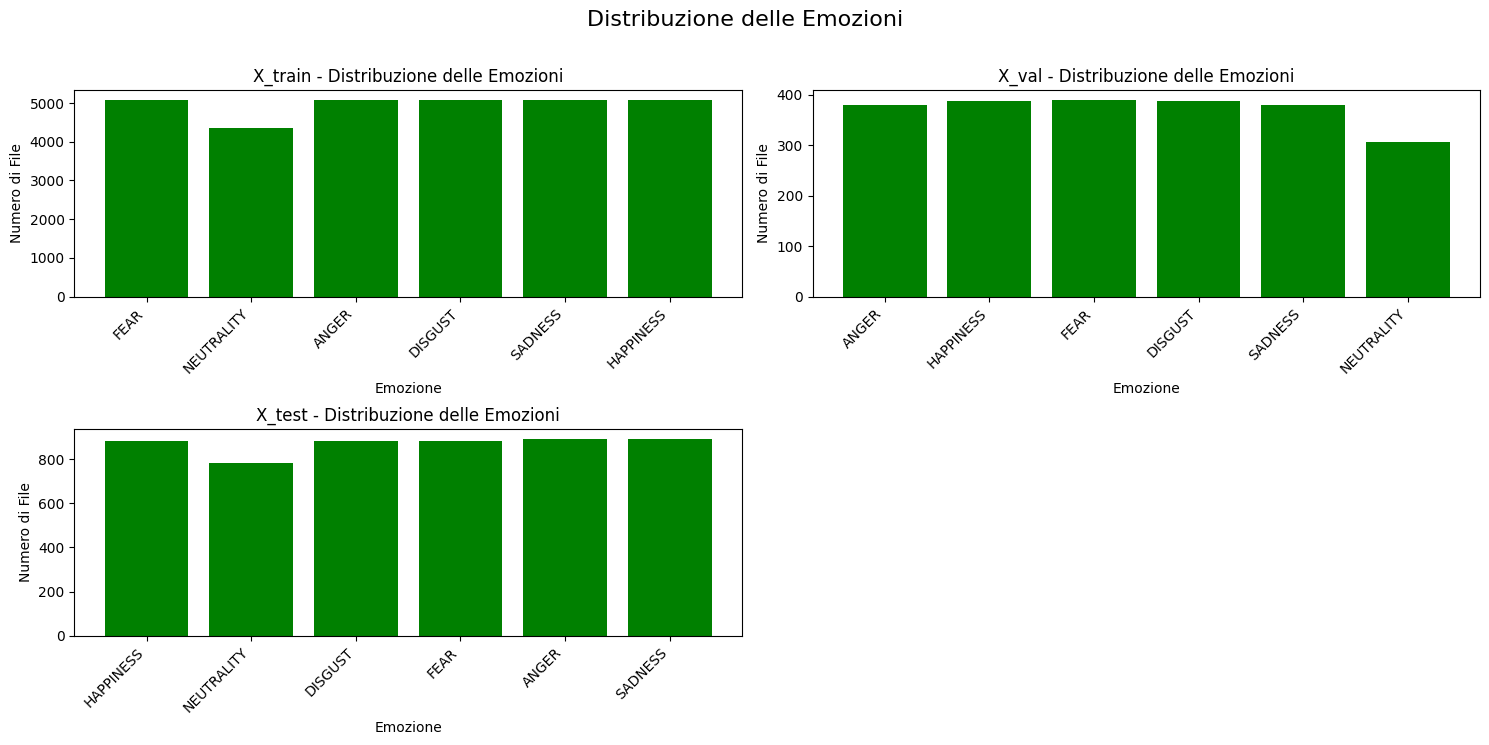

In [18]:
# Controllo della distribuzione delle emozioni dopo lo splitting

X_train_5, X_val_5, X_test_5, y_train_5, y_val_5, y_test_5 = folds[0]
train_emotion_counts = Counter(y_train_5)
val_emotion_counts = Counter(y_val_5)
test_emotion_counts = Counter(y_test_5)
plot_emotion_distributions(train_emotion_counts, val_emotion_counts, test_emotion_counts)

In [19]:
X_train_5.shape, X_val_5.shape, X_test_5.shape, y_train_5.shape, y_val_5.shape, y_test_5.shape

((29768, 193), (2232, 193), (5210, 193), (29768,), (2232,), (5210,))

In [20]:
# Reshaping

X_train_res_5 = X_train_5.reshape((X_train_5.shape[0], X_train_5.shape[1], 1))
X_test_res_5 = X_test_5.reshape((X_test_5.shape[0], X_test_5.shape[1], 1))
X_val_res_5 = X_val_5.reshape((X_val_5.shape[0], X_val_5.shape[1], 1))

In [21]:
X_train_res_5.shape, X_val_res_5.shape, X_test_res_5.shape

((29768, 193, 1), (2232, 193, 1), (5210, 193, 1))

In [22]:
# One-Hot Enconding

encoder = OneHotEncoder(sparse_output=False)
y_train_enc_5 = encoder.fit_transform(y_train_5.reshape(-1, 1))
y_test_enc_5 = encoder.transform(y_test_5.reshape(-1, 1))
y_val_enc_5 = encoder.transform(y_val_5.reshape(-1, 1))

In [23]:
y_train_enc_5.shape, y_test_enc_5.shape, y_val_enc_5.shape

((29768, 6), (5210, 6), (2232, 6))

In [24]:
# Creazione del modello

model5 = Sequential()
model5.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_res_5.shape[1], X_train_res_5.shape[2])))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Dropout(0.2))
model5.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model5.add(MaxPooling1D(pool_size=2))
model5.add(Dropout(0.2))
model5.add(Flatten())
model5.add(Dense(64, activation='relu'))
model5.add(Dense(y_train_enc_5.shape[1], activation='softmax'))
model5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model5.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 191, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 95, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 95, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 93, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 46, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 46, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 5888)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         376,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 402,246 (1.53 MB)

 Trainable params: 402,246 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Fitting

history = model5.fit(X_train_res_5, y_train_enc_5, validation_data=(X_val_res_5, y_val_enc_5), epochs=100, batch_size=32)

Epoch 1/100
931/931 ━━━━━━━━━━━━━━━━━━━━ 33s 34ms/step - accuracy: 0.3326 - loss: 1.6487 - val_accuracy: 0.4256 - val_loss: 1.3794
Epoch 2/100
931/931 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.4263 - loss: 1.3937 - val_accuracy: 0.4503 - val_loss: 1.3455
Epoch 3/100
931/931 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.4445 - loss: 1.3536 - val_accuracy: 0.4776 - val_loss: 1.2951
Epoch 4/100
931/931 ━━━━━━━━━━━━━━━━━━━━ 30s 32ms/step - accuracy: 0.4663 - loss: 1.3168 - val_accuracy: 0.4875 - val_loss: 1.2670
Epoch 5/100
931/931 ━━━━━━━━━━━━━━━━━━━━ 42s 34ms/step - accuracy: 0.4770 - loss: 1.2881 - val_accuracy: 0.4973 - val_loss: 1.2531
Epoch 6/100
931/931 ━━━━━━━━━━━━━━━━━━━━ 40s 32ms/step - accuracy: 0.4860 - loss: 1.2655 - val_accuracy: 0.4982 - val_loss: 1.2411
Epoch 7/100
931/931 ━━━━━━━━━━━━━━━━━━━━ 41s 32ms/step - accuracy: 0.5013 - loss: 1.2413 - val_accuracy: 0.5130 - val_loss: 1.2055
Epoch 8/100
931/931 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step - accuracy: 0.5107 - loss: 1

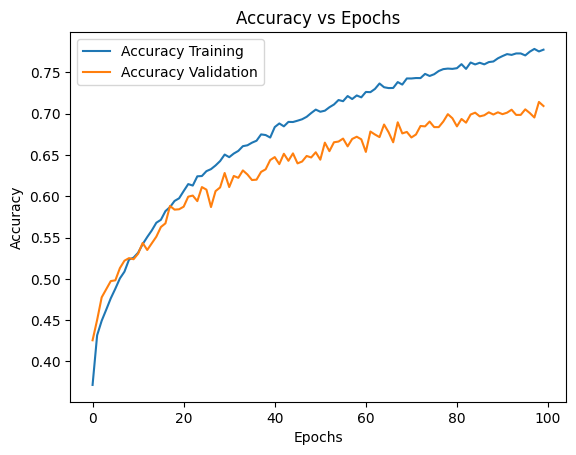

In [26]:
# Andamento accuracy

plt.plot(history.history['accuracy'], label='Accuracy Training')
plt.plot(history.history['val_accuracy'], label='Accuracy Validation')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

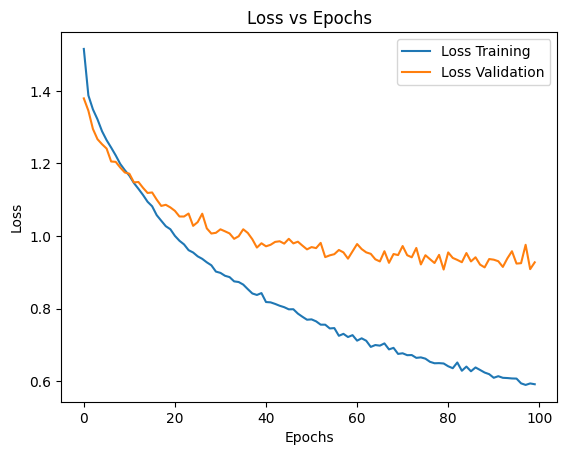

In [27]:
# Andamento loss

plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validation')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [28]:
# Valutazione del modello

accuracy_5 = model5.evaluate(X_test_res_5, y_test_enc_5)
print(f"Test Accuracy: {100*accuracy_5[1]:.2f}%")

163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.6993 - loss: 0.9570
Test Accuracy: 68.71%


In [72]:
y_pred_5 = model5.predict(X_test_res_5)
y_pred_enc_5 = np.argmax(y_pred_5, axis=1)
y_test_encoded_5 = np.argmax(y_test_enc_5, axis=1)

163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


In [30]:
print("Rapporto di classificazione:")
print(classification_report(y_test_encoded_5, y_pred_enc_5, target_names=np.unique(y_5)))

Rapporto di classificazione:
              precision    recall  f1-score   support

       ANGER       0.82      0.81      0.82       891
     DISGUST       0.55      0.68      0.60       883
        FEAR       0.70      0.64      0.67       881
   HAPPINESS       0.71      0.73      0.72       883
  NEUTRALITY       0.71      0.61      0.66       781
     SADNESS       0.68      0.65      0.66       891

    accuracy                           0.69      5210
   macro avg       0.69      0.69      0.69      5210
weighted avg       0.69      0.69      0.69      5210



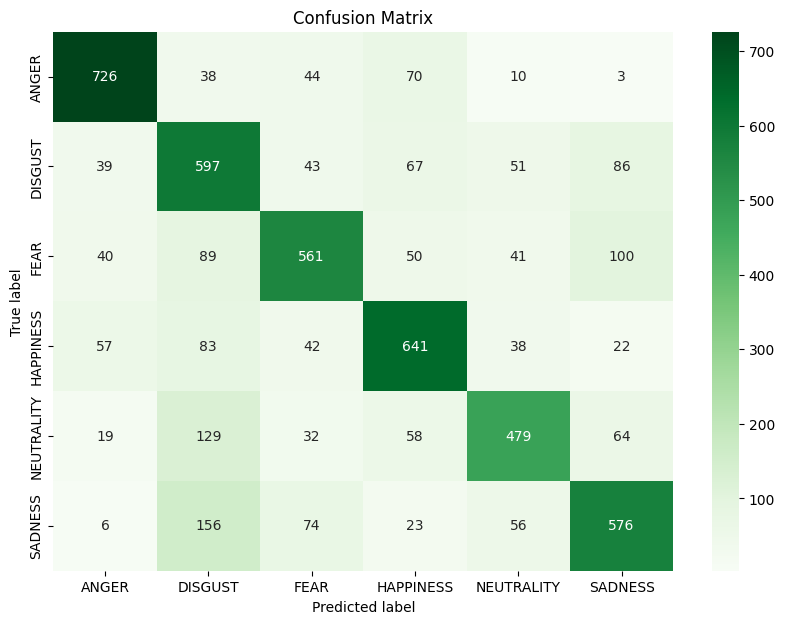

In [31]:
# Matrice di confusione

conf_matrix = confusion_matrix(y_test_encoded_5, y_pred_enc_5)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=np.unique(y_5), yticklabels=np.unique(y_5))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

In [79]:
# Dizionario di mapping delle etichette numeriche ai nomi delle emozioni

label_to_emotion = {
    0: "Anger",
    1: "Disgust",
    2: "Fear",
    3: "Happiness",
    4: "Neutrality",
    5: "Sadness"
}

In [80]:
# Identificazione delle etichette misclassificate

misclassified_indices = np.where(y_test_encoded_5 != y_pred_enc_5)[0]
misclassified_labels = y_test_encoded_5[misclassified_indices]
predicted_labels = y_pred_enc_5[misclassified_indices]
misclassification_counts = Counter(zip(misclassified_labels, predicted_labels))
total_counts = Counter(y_test_encoded_5)
misclassification_percentage = {}

for (true_label, predicted_label), count in misclassification_counts.items():
    if true_label not in misclassification_percentage:
        misclassification_percentage[true_label] = 0
    misclassification_percentage[true_label] += count

for label in total_counts:
    if label in misclassification_percentage:
        misclassification_percentage[label] = (misclassification_percentage[label] / total_counts[label]) * 100
    else:
        misclassification_percentage[label] = 0.0
sorted_misclassification = sorted(misclassification_percentage.items(), key=lambda x: x[1], reverse=True)
print("\nPercentuale di misclassificazione per emozione:\n" + "-"*50)
print(f"{'Emozione':<15} {'Percentuale (%)':<15}")
print("-"*50)
for label, percentage in sorted_misclassification:
    emotion_name = label_to_emotion.get(label, "Unknown")
    print(f"{emotion_name:<15} {percentage:<15.2f}")
print("-"*50)


Percentuale di misclassificazione per emozione:
--------------------------------------------------
Emozione        Percentuale (%)
--------------------------------------------------
Neutrality      38.67          
Fear            36.32          
Sadness         35.35          
Disgust         32.39          
Happiness       27.41          
Anger           18.52          
--------------------------------------------------


# ANALISI DEL CASO 2
### 10 CARATTERISTICHE ESTRATTE

In [33]:
total_df = pd.read_pickle('/content/drive/MyDrive/ABEC/Totale2.pkl')

In [34]:
# Statitiche del dataset

total_df.shape

(37210, 11)

In [35]:
total_df.head()

,mfcc,chroma,mel,tonnetz,spectral_contrast,label,zero-crossing,hnr,teo,ste,psd
0,"[-346.29526, 137.64049, 8.69169, 35.311882, -9...","[0.29201826, 0.38502562, 0.29120973, 0.3123079...","[0.07737846, 0.034783144, 0.04425149, 0.062268...","[-0.0430883237494016, -0.05187423004202757, -0...","[13.31842625645253, 16.873059068316007, 20.454...",ANGER,[0.06904810855263158],4.752542,[0.037368394],[0.037368394],118.536977
1,"[-205.49876879272944, 44.45666724381474, 22.02...","[0.39116075441203946, 0.4594201150786906, 0.38...","[0.08461332760294109, 0.04076906607106719, 0.0...","[-0.04235175747574739, -0.058032173052157694, ...","[12.685969741383444, 15.88780895567124, 18.579...",ANGER,[0.1859631990131579],4.735016,[0.038343303],[0.038343303],120.125759
2,"[-375.05515, 132.2356, 10.073215, 30.356653, -...","[0.29833022, 0.37963942, 0.2675938, 0.32496527...","[0.037430894, 0.015797297, 0.018807301, 0.0287...","[-0.07300732215248174, -0.052441760849361405, ...","[14.125213326380202, 17.16686360031749, 21.117...",ANGER,[0.07325860031512606],5.701991,[0.026131568],[0.026131568],74.026113
3,"[-344.04053, 137.3057, 9.162203, 34.567955, -9...","[0.32881013, 0.37016758, 0.27752447, 0.3208849...","[0.079234466, 0.035795696, 0.045172043, 0.0623...","[-0.0706774184565807, -0.05674157194124169, -0...","[13.294224923946032, 16.549524811498856, 20.30...",ANGER,[0.06951069078947368],4.189364,[0.03755513],[0.03755513],118.536977
4,"[-345.86893, 116.51579, 9.756774, 5.285912, -7...","[0.2184162, 0.2955816, 0.3488706, 0.49626875, ...","[0.027997933, 0.019921398, 0.008562651, 0.0155...","[-0.08157975611316184, -0.008267977533426438, ...","[13.975499943771492, 16.00863120845709, 21.480...",ANGER,[0.09182771381578947],2.037568,[0.027112331],[0.027112331],63.006963


In [36]:
# Divisione in etichette e dati

X_10 = total_df[['mfcc', 'chroma', 'mel', 'tonnetz', 'spectral_contrast', 'zero-crossing', 'hnr', 'teo', 'ste', 'psd']].apply(
    safe_concatenate, axis=1).tolist()
y_10 = total_df['label']
X_10 = np.array(X_10)
y_10 = np.array(y_10)
X_10, y_10

(array([[-3.46295258e+02,  1.37640488e+02,  8.69169044e+00, ...,
          3.73683944e-02,  3.73683944e-02,  1.18536977e+02],
        [-2.05498769e+02,  4.44566672e+01,  2.20275432e+01, ...,
          3.83433029e-02,  3.83433029e-02,  1.20125759e+02],
        [-3.75055145e+02,  1.32235596e+02,  1.00732145e+01, ...,
          2.61315685e-02,  2.61315685e-02,  7.40261127e+01],
        ...,
        [-4.70808655e+02,  1.55671173e+02,  1.29026289e+01, ...,
          8.16561934e-03,  8.16561934e-03,  6.61773854e+00],
        [-4.33563965e+02,  1.55600235e+02,  1.53618965e+01, ...,
          1.21792322e-02,  1.21792322e-02,  1.18443580e+01],
        [-4.28234192e+02,  1.37385529e+02,  2.59889259e+01, ...,
          8.50192830e-03,  8.50192830e-03,  5.66765040e+00]]),
 array(['ANGER', 'ANGER', 'ANGER', ..., 'SADNESS', 'SADNESS', 'SADNESS'],
       dtype=object))

In [37]:
# Randomizzazione

X_10, y_10 = shuffle(X_10, y_10, random_state=42)
X_10, y_10

(array([[-4.63228790e+02,  1.48453018e+02,  1.51960392e+01, ...,
          7.90839829e-03,  7.90839829e-03,  4.64036931e+00],
        [-4.04307831e+02,  1.19549072e+02,  2.41388302e+01, ...,
          8.43652431e-03,  8.43652431e-03,  4.86639238e+00],
        [-2.74882629e+02,  8.38331223e+01, -2.12560234e+01, ...,
          6.99278638e-02,  6.99278638e-02,  7.13554146e+02],
        ...,
        [-4.50558899e+02,  1.03285767e+02,  3.50238380e+01, ...,
          5.80985192e-03,  5.80985192e-03,  2.57028738e+00],
        [-4.15588928e+02,  1.55202393e+02,  1.67220535e+01, ...,
          1.32566523e-02,  1.32566523e-02,  1.38155247e+01],
        [-3.92142975e+02,  1.40391953e+02,  7.99204969e+00, ...,
          1.99222211e-02,  1.99222211e-02,  5.37350282e+01]]),
 array(['FEAR', 'NEUTRALITY', 'ANGER', ..., 'DISGUST', 'ANGER', 'FEAR'],
       dtype=object))

In [38]:
# Splitting

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
folds = []
for train_index, test_index in skf.split(X_10, y_10):
    X_train_10, X_temp = X_10[train_index], X_10[test_index]
    y_train_10, y_temp = y_10[train_index], y_10[test_index]
    val_split = int(0.3 * len(X_temp))
    X_val_10, X_test_10 = X_temp[:val_split], X_temp[val_split:]
    y_val_10, y_test_10 = y_temp[:val_split], y_temp[val_split:]
    folds.append((X_train_10, X_val_10, X_test_10, y_train_10, y_val_10, y_test_10))

In [39]:
X_train_10.shape, X_val_10.shape, X_test_10.shape, y_train_10.shape, y_val_10.shape, y_test_10.shape

((29768, 198), (2232, 198), (5210, 198), (29768,), (2232,), (5210,))

<ipython-input-6-f1776271b041>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.keys(), rotation=45, ha='right')
<ipython-input-6-f1776271b041>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.keys(), rotation=45, ha='right')
<ipython-input-6-f1776271b041>:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(counts.keys(), rotation=45, ha='right')


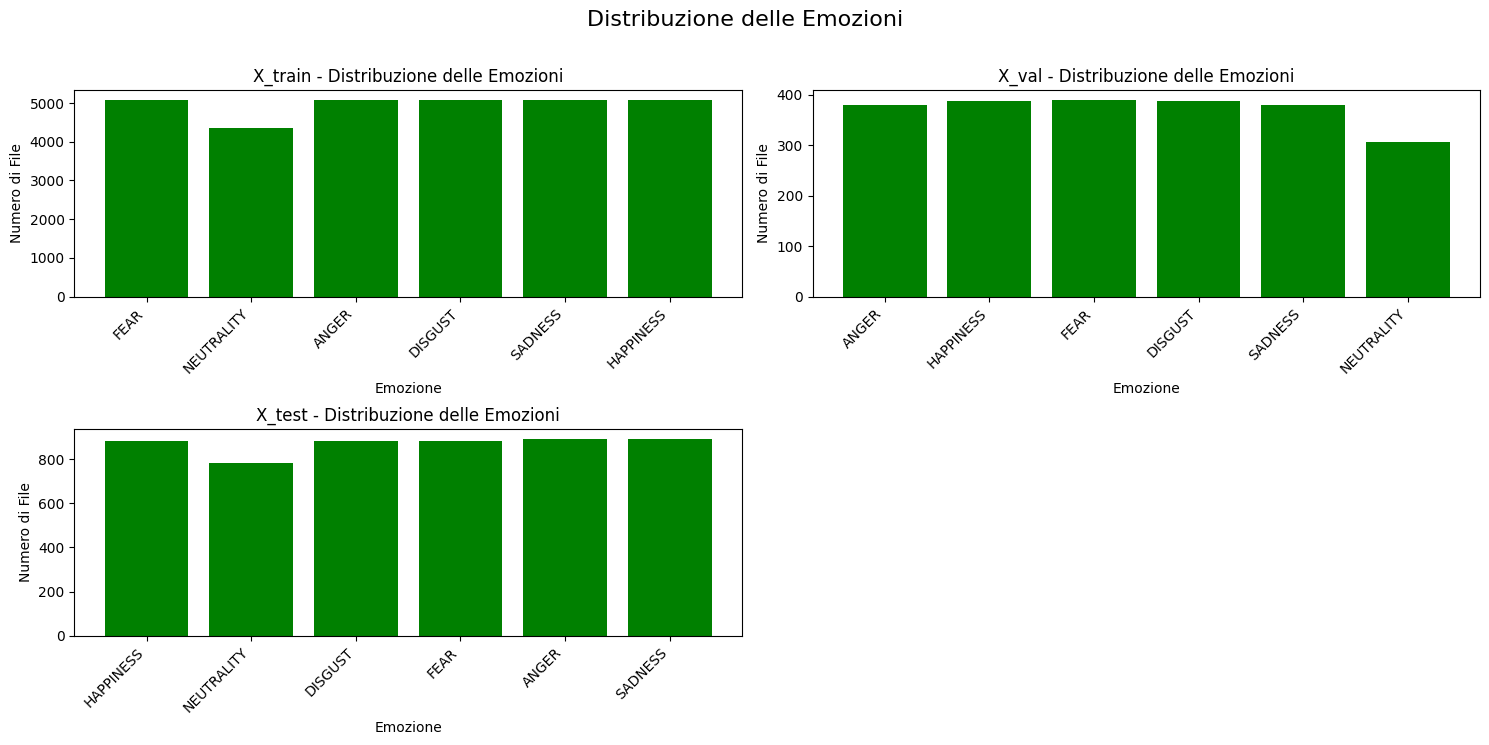

In [40]:
# Controllo della distribuzione delle emozioni dopo lo splitting

X_train_10, X_val_10, X_test_10, y_train_10, y_val_10, y_test_10 = folds[0]
train_emotion_counts = Counter(y_train_10)
val_emotion_counts = Counter(y_val_10)
test_emotion_counts = Counter(y_test_10)
plot_emotion_distributions(train_emotion_counts, val_emotion_counts, test_emotion_counts)

In [41]:
# Reshaping

X_train_res_10 = X_train_10.reshape((X_train_10.shape[0], X_train_10.shape[1], 1))
X_test_res_10 = X_test_10.reshape((X_test_10.shape[0], X_test_10.shape[1], 1))
X_val_res_10 = X_val_10.reshape((X_val_10.shape[0], X_val_10.shape[1], 1))

In [42]:
X_train_res_10.shape, X_val_res_10.shape, X_test_res_10.shape

((29768, 198, 1), (2232, 198, 1), (5210, 198, 1))

In [43]:
# One-Hot Enconding

encoder = OneHotEncoder(sparse_output=False)
y_train_enc_10 = encoder.fit_transform(y_train_10.reshape(-1, 1))
y_test_enc_10 = encoder.transform(y_test_10.reshape(-1, 1))
y_val_enc_10 = encoder.transform(y_val_10.reshape(-1, 1))

In [44]:
y_train_enc_10.shape, y_test_enc_10.shape, y_val_enc_10.shape

((29768, 6), (5210, 6), (2232, 6))

In [45]:
# Creazione del modello

model10 = Sequential()
model10.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train_res_10.shape[1], X_train_res_10.shape[2])))
model10.add(MaxPooling1D(pool_size=2))
model10.add(Dropout(0.2))
model10.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model10.add(MaxPooling1D(pool_size=2))
model10.add(Dropout(0.2))
model10.add(Flatten())
model10.add(Dense(64, activation='relu'))
model10.add(Dense(y_train_enc_10.shape[1], activation='softmax'))
model10.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model10.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 196, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 98, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 98, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 96, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 48, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 48, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 6144)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │         393,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 418,630 (1.60 MB)

 Trainable params: 418,630 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# Fitting

history = model10.fit(X_train_res_10, y_train_enc_10, validation_data=(X_val_res_10, y_val_enc_10), epochs=100, batch_size=32)

Epoch 1/100
931/931 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - accuracy: 0.3258 - loss: 1.6838 - val_accuracy: 0.3831 - val_loss: 1.4570
Epoch 2/100
931/931 ━━━━━━━━━━━━━━━━━━━━ 37s 33ms/step - accuracy: 0.4147 - loss: 1.4302 - val_accuracy: 0.4364 - val_loss: 1.3585
Epoch 3/100
931/931 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.4308 - loss: 1.3826 - val_accuracy: 0.4673 - val_loss: 1.3216
Epoch 4/100
931/931 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.4556 - loss: 1.3492 - val_accuracy: 0.4785 - val_loss: 1.2994
Epoch 5/100
931/931 ━━━━━━━━━━━━━━━━━━━━ 41s 33ms/step - accuracy: 0.4611 - loss: 1.3266 - val_accuracy: 0.4677 - val_loss: 1.2987
Epoch 6/100
931/931 ━━━━━━━━━━━━━━━━━━━━ 31s 34ms/step - accuracy: 0.4702 - loss: 1.3144 - val_accuracy: 0.5000 - val_loss: 1.2623
Epoch 7/100
931/931 ━━━━━━━━━━━━━━━━━━━━ 30s 33ms/step - accuracy: 0.4855 - loss: 1.2828 - val_accuracy: 0.4928 - val_loss: 1.2566
Epoch 8/100
931/931 ━━━━━━━━━━━━━━━━━━━━ 31s 33ms/step - accuracy: 0.4995 - loss: 1

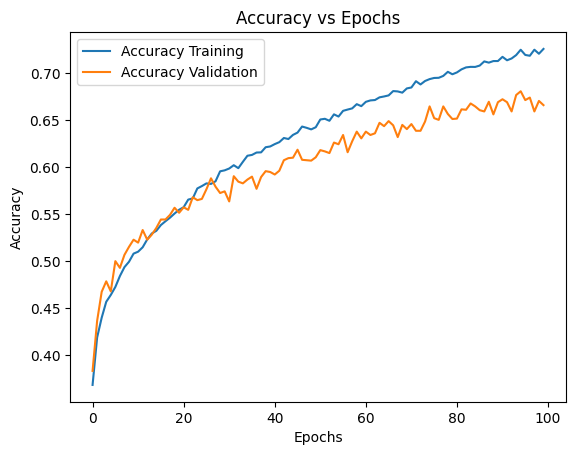

In [47]:
# Andamento accuracy

plt.plot(history.history['accuracy'], label='Accuracy Training')
plt.plot(history.history['val_accuracy'], label='Accuracy Validation')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

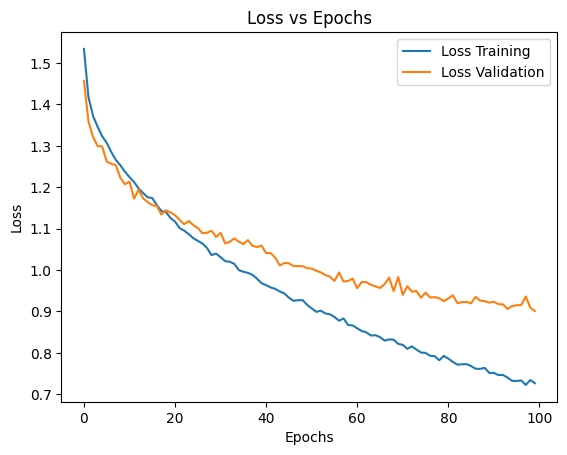

In [48]:
# Andamento loss

plt.plot(history.history['loss'], label='Loss Training')
plt.plot(history.history['val_loss'], label='Loss Validation')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [49]:
# Valutazione del modello

accuracy_10 = model10.evaluate(X_test_res_10, y_test_enc_10)
print(f"Test Accuracy: {100*accuracy_10[1]:.2f}%")

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6694 - loss: 0.9674
Test Accuracy: 66.68%


In [50]:
y_pred_10 = model10.predict(X_test_res_10)
y_pred_enc_10 = np.argmax(y_pred_10, axis=1)
y_test_encoded_10 = np.argmax(y_test_enc_10, axis=1)

163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


In [51]:
print("Rapporto di classificazione:")
print(classification_report(y_test_encoded_10, y_pred_enc_10, target_names=np.unique(y_10)))

Rapporto di classificazione:
              precision    recall  f1-score   support

       ANGER       0.81      0.80      0.80       891
     DISGUST       0.61      0.58      0.59       883
        FEAR       0.64      0.62      0.63       881
   HAPPINESS       0.69      0.67      0.68       883
  NEUTRALITY       0.63      0.67      0.65       781
     SADNESS       0.62      0.66      0.64       891

    accuracy                           0.67      5210
   macro avg       0.67      0.67      0.67      5210
weighted avg       0.67      0.67      0.67      5210



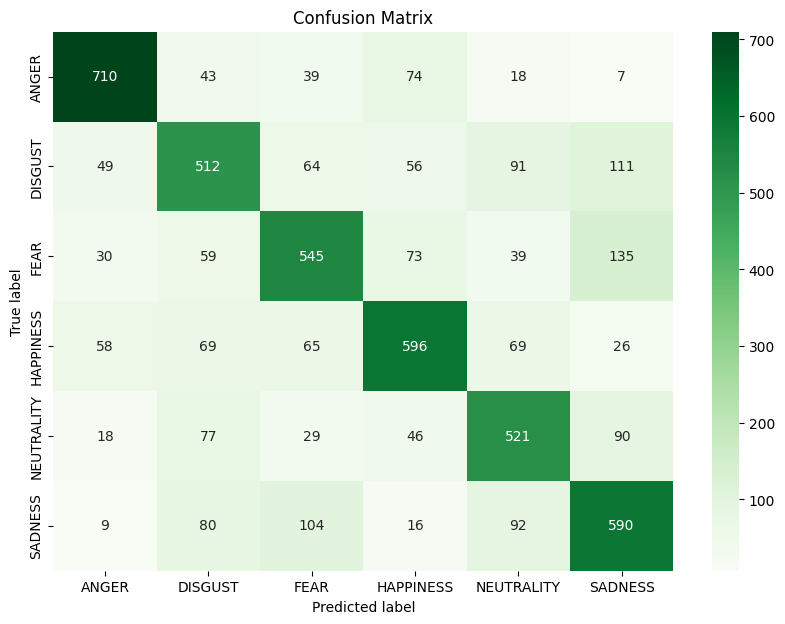

In [52]:
# Matrice di confusione

conf_matrix = confusion_matrix(y_test_encoded_10, y_pred_enc_10)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens',
            xticklabels=np.unique(y_10), yticklabels=np.unique(y_10))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()

In [77]:
# Dizionario di mapping delle etichette numeriche ai nomi delle emozioni

label_to_emotion = {
    0: "Anger",
    1: "Disgust",
    2: "Fear",
    3: "Happiness",
    4: "Neutrality",
    5: "Sadness"
}

In [78]:
# Identificazione delle etichette misclassificate

misclassified_indices = np.where(y_test_encoded_10 != y_pred_enc_10)[0]
misclassified_labels = y_test_encoded_10[misclassified_indices]
predicted_labels = y_pred_enc_10[misclassified_indices]
misclassification_counts = Counter(zip(misclassified_labels, predicted_labels))
total_counts = Counter(y_test_encoded_10)
misclassification_percentage = {}

for (true_label, predicted_label), count in misclassification_counts.items():
    if true_label not in misclassification_percentage:
        misclassification_percentage[true_label] = 0
    misclassification_percentage[true_label] += count

for label in total_counts:
    if label in misclassification_percentage:
        misclassification_percentage[label] = (misclassification_percentage[label] / total_counts[label]) * 100
    else:
        misclassification_percentage[label] = 0.0
sorted_misclassification = sorted(misclassification_percentage.items(), key=lambda x: x[1], reverse=True)
print("\nPercentuale di misclassificazione per emozione:\n" + "-"*50)
print(f"{'Emozione':<15} {'Percentuale (%)':<15}")
print("-"*50)
for label, percentage in sorted_misclassification:
    emotion_name = label_to_emotion.get(label, "Unknown")
    print(f"{emotion_name:<15} {percentage:<15.2f}")
print("-"*50)


Percentuale di misclassificazione per emozione:
--------------------------------------------------
Emozione        Percentuale (%)
--------------------------------------------------
Disgust         42.02          
Fear            38.14          
Sadness         33.78          
Neutrality      33.29          
Happiness       32.50          
Anger           20.31          
--------------------------------------------------


# VALUTAZIONI CONCLUSIVE

In [74]:
# Valutazione caso 1

acc5 = accuracy_score(y_test_encoded_5, y_pred_enc_5)
prec5 = precision_score(y_test_encoded_5, y_pred_enc_5, average='weighted')
rec5 = recall_score(y_test_encoded_5, y_pred_enc_5, average='weighted')
f15 = f1_score(y_test_encoded_5, y_pred_enc_5, average='weighted')
acc5 = f"{acc5 * 100:.2f}%"
prec5 = f"{prec5 * 100:.2f}%"
rec5 = f"{rec5 * 100:.2f}%"
f15 = f"{f15 * 100:.2f}%"

In [75]:
# Valutazione caso 2

acc10 = accuracy_score(y_test_encoded_10, y_pred_enc_10)
prec10 = precision_score(y_test_encoded_10, y_pred_enc_10, average='weighted')
rec10 = recall_score(y_test_encoded_10, y_pred_enc_10, average='weighted')
f110 = f1_score(y_test_encoded_10, y_pred_enc_10, average='weighted')
acc10 = f"{acc10 * 100:.2f}%"
prec10 = f"{prec10 * 100:.2f}%"
rec10 = f"{rec10 * 100:.2f}%"
f110 = f"{f110 * 100:.2f}%"

In [76]:
# Valutazione finale

data = {
    'Metriche': ['Accuracy', 'Precision', 'Recall', 'F1-score'],
    'Modello con 5 caratteristiche': [acc5, prec5, rec5, f15],
    'Modello con 10 caratteristiche': [acc10, prec10, rec10, f110]
}
results = pd.DataFrame(data)
display(results)

,Metriche,Modello con 5 caratteristiche,Modello con 10 caratteristiche
0,Accuracy,68.71%,66.68%
1,Precision,69.35%,66.78%
2,Recall,68.71%,66.68%
3,F1-score,68.82%,66.69%
